In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

.\data\labels.txt
.\data\P812_M050_2_B_FoG_trial1_annotation.csv
.\data\P812_M050_2_B_FoG_trials.mat
.\data\P812_M050_2_B_FoG_trial_1_emg.csv
.\data\P812_M050_2_B_FoG_trial_1_out_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_lower_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_lower_right_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_right_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_emg.csv
.\data\P812_M050_2_B_FoG_trial_2_out_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_out_lower_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_out_lower_right_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_out_right_foot.csv
.\data\P812_M50_2_B_FoG_trial2_annotation.csv


In [4]:
emg_data = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_emg.csv')
t1olf = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_out_left_foot.csv')
emg_data2 = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_2_emg.csv')

In [144]:
emg_data = emg_data.fillna(method='ffill')
emg_data.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [9]:
def generate_window_slide_data(data,width = 260, stride = 30):
    l = len(data)
    end = (l-width)//stride+1
    X = []
    Y = []
    for i in range(end):
        if len(set(data.Label2[i*stride:i*stride+width])) == 1:
                Y += [data.Label2[i*stride]]
                X += [np.array(data.iloc[i*stride:i*stride+width,3:])]
            #print(set(data.Label2[i*stride:i*stride+width]))
        else:
            #print(set(data.Label2[i*stride:i*stride+width]))
            continue
    return np.array(X,dtype=np.float32),np.array(Y,dtype=np.uint8)

def generate_CWT_feature(data,widths=260,wavelet = signal.ricker):
    n,t,c = data.shape
    cwtmatr = np.zeros((n,widths,t,c))
    for i in range(n):
        for j in range(c):
            cwtmatr[i,:,:,j] = signal.cwt(data[i,:,j],wavelet,np.arange(1,widths+1))
    return cwtmatr

In [38]:
file = './processed data/P812_trial_1_W%d_S%d_WS%d_CWT.hdf5'%(260,30,260)
with h5py.File(file,'w') as f:
    f.create_dataset('cwt_data',data=cwtmatr, maxshape=(None,260,260,8),
                     chunks = True,dtype = np.float32)
    f.create_dataset('label2',data=y, dtype = np.int8)

In [145]:
width = 150
stride = 30
widths_scale = 150
x,y = generate_window_slide_data(emg_data,width,stride)

In [157]:
(np.isnan(cwtmatr)).sum()

0

In [147]:
#ind = ((y == 0) | (y == 2))
cwtmatr = generate_CWT_feature(x,widths_scale)

In [14]:
import h5py

file = './processed data/P812_trial_1_W260_S30_WS260_CWT.hdf5'
with h5py.File(file,'w') as f:
    f.create_dataset('cwt_data',data=cwtmatr,dtype=np.float32)
    f.create_dataset('label2',data=y,dtype=np.uint8)

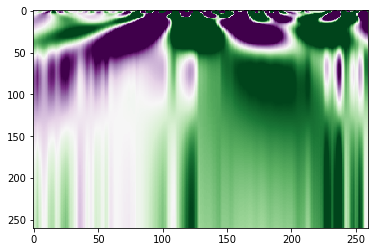

In [21]:
plt.imshow(cwtmatr_train_full[1000,:,:,0], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr_train_full[0,:,:,0]).max(), 
           vmin=-abs(cwtmatr_train_full[0,:,:,0]).max())

In [156]:
#label = y[ind]
#label[label==2]=1
cwtmatr = (cwtmatr-cwtmatr.min())/(cwtmatr.max()-cwtmatr.min())

In [148]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import save_model
from tensorflow.keras import callbacks, Model
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import ELU
from sklearn.preprocessing import OneHotEncoder

In [163]:
input_ = Input(shape=cwtmatr.shape[1:])
max_pool = MaxPooling2D(2)(input_)
conv1 = Conv2D(64,5,strides=(2,2),kernel_initializer=TruncatedNormal(),activation='relu',padding='same')(max_pool)
max_pool1 = MaxPooling2D(2)(conv1)
conv2 = Conv2D(128,5,strides=(2,2),kernel_initializer=TruncatedNormal(),activation='relu',padding='same')(max_pool1)
max_pool2 = MaxPooling2D(2)(conv2)
flatten = Flatten()(max_pool2)
layer1 = Dense(256,activation = 'relu')(flatten)
layer2 = Dense(128,activation = 'relu')(layer1)
output = Dense(2,activation = 'softmax')(layer2)
model = Model(inputs=[input_],outputs=[output])

In [164]:
bce = CategoricalCrossentropy()
model.compile(loss =bce ,optimizer='adam',metrics=['accuracy'])
oh_ec = OneHotEncoder()
label = oh_ec.fit_transform(y[ind,np.newaxis]).toarray()

In [165]:
ind = ((y==0) | (y==2))
history = model.fit(cwtmatr[ind],label,validation_split=0.2,epochs=10,batch_size=50)

Train on 1632 samples, validate on 408 samples
Epoch 1/10
1632/1632 [==============================] - 18s 11ms/sample - loss: 0.6997 - accuracy: 0.6011 - val_loss: 0.6603 - val_accuracy: 0.6299
Epoch 2/10
1632/1632 [==============================] - 12s 7ms/sample - loss: 0.6669 - accuracy: 0.6262 - val_loss: 0.6586 - val_accuracy: 0.6299
Epoch 3/10
1632/1632 [==============================] - 9s 6ms/sample - loss: 0.6623 - accuracy: 0.6262 - val_loss: 0.6593 - val_accuracy: 0.6299
Epoch 4/10
1632/1632 [==============================] - 9s 6ms/sample - loss: 0.6617 - accuracy: 0.6262 - val_loss: 0.6602 - val_accuracy: 0.6299
Epoch 5/10
1632/1632 [==============================] - 9s 6ms/sample - loss: 0.6603 - accuracy: 0.6262 - val_loss: 0.6583 - val_accuracy: 0.6299
Epoch 6/10
1632/1632 [==============================] - 9s 5ms/sample - loss: 0.6641 - accuracy: 0.6262 - val_loss: 0.6660 - val_accuracy: 0.6299
Epoch 7/10
1632/1632 [==============================] - 10s 6ms/sample - l

In [168]:
label.shape

(2040, 2)

In [167]:
y_pred = model.predict(cwtmatr[:3])
y_pred

array([[0.37765244, 0.6223476 ],
       [0.37764174, 0.62235826],
       [0.3776543 , 0.62234575]], dtype=float32)

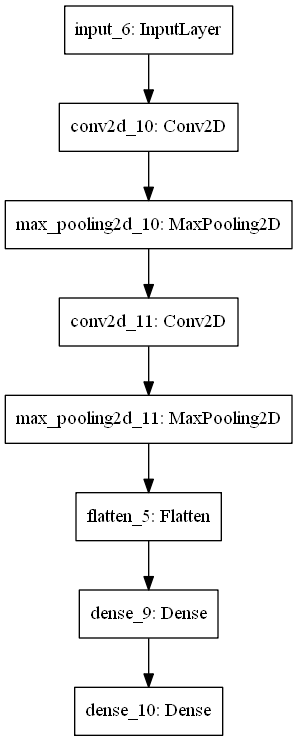

In [61]:
plot_model(model)

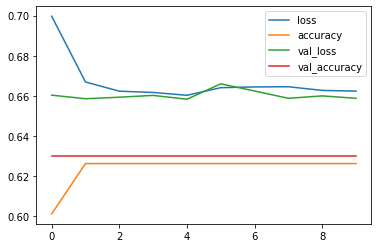

In [170]:
pd.DataFrame(history.history).plot()